In [52]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=3,n_informative=3,
                          n_redundant=0,n_clusters_per_class=1,
                          flip_y=0.1, #adds small amount of noise
                          class_sep=1.0, #classes are separable but not too easily
                          random_state=40)

y = [-1 if value == 0 else value for value in y]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 1. Relabel the Y targets to +1/-1

In [53]:
y = [-1 if value == 0 else value for value in y]
print(y)

[1, -1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1

# 2. Split the dataset into training and testing datasets

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
n_samples, n_features = X_train.shape

# 3. Implement soft margin SVM

notes: class_1 (y_1) = -1, class_2 (y_2) = +1 
we have Wx+b is the eqn of a line that is in the center of the margin. then we have W*x+b<-1 class one and W*x+b>1 class 2. 

So if correctly classified, y*(wx+b)>1. 

we also want to maximize 2/||w|| or minimize ||w||/2. why? this follows from the fact that we want to maximize the distance between two correctly classified points. d=2/||w||

for soft margin svm: d = 2/||w|| + c*sum(epsillons). where epsillons = distance of misclassified points to its correct marginl. 

In [55]:
def sm_svm(X_train, y_train, lr = 0.0000001, lmbda = 0.001):

    np.random.seed(123)
    weights = np.random.randn(n_features) * 0.001
    b = 0
    losses = []
    for _ in range(10000):
        loss = 0 
        for index, x_i in enumerate(X_train):
            #compute the decision value for a data point
            sign = y_train[index] * (np.dot(x_i, weights) + b)
            
            loss += np.maximum(0, 1 - sign)
            
            if sign >= 1:
                # update the gradient for correctly classified
                weights -= lr * 2 * lmbda * weights
            else:
                b -= lr * y_train[index]
                weights -= lr * (2 * lmbda * weights - (y_train[index]*x_i))
                
                
        loss += lmbda * np.dot(weights,weights)
        losses.append(loss/X_train.shape[0])
    return weights, b, losses

new_weights, new_b, losses1 = sm_svm(X_train,y_train)
y_pred = np.sign(np.dot(X_test, new_weights)+new_b)
print("optimal weights and b:", new_weights, new_b)
print("accuracy score:", accuracy_score(y_test,y_pred))



optimal weights and b: [-0.33558085 -0.34343154 -0.05776046] 0.022830299999918677
accuracy score: 0.8


# 4. Use mini batch gradient descent to minimize the loss function on the next page (shuffle the data first).

In [56]:
def shuffle(X,y):
    """shuffles X,y, while keeping the correspondence"""
    y = np.array(y)
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices, :]
    y_shuffled = y[indices]

    return X_shuffled, y_shuffled

X_shuffled, y_shuffled = shuffle(X_train, y_train)

def m_mini_batches(X,y,m):
    """takes X, y, and m - a number of desired mini batch sizes
    returns a list of tuples, each tuple containing one mini batch in the form of(X, y)"""
    n = len(X)
    assert m <= n
    if m >n:
        return 
    mini_batch_list = []
    
    for i in range(0,n,m):
        X_mini = X[i:i+m]
        y_mini = y[i:i+m]
        mini_batch_list.append((X_mini,y_mini))
        
    return mini_batch_list


# mini batch gradient descent support vector machines
def mb_gd_svm(X_train,y_train,lr=0.0000001,lmbda=0.000001,iters=10000,batch_size=64):
    
    # shuffle and create mini batches
    X_shuffled, y_shuffled = shuffle(X_train, y_train)
    mini_batch_list = m_mini_batches(X_shuffled,y_shuffled, batch_size)
    
    #initialize w,b
    np.random.seed(42)
    w = np.random.randn(X_train.shape[1]) * 0.001
    b=0
    losses = []
    
    for _ in range(iters):
        loss = 0 
        # for each batch sum up dw and db 
        
        for batch in mini_batch_list:
            X_mini, y_mini = batch 
            np.random.seed(42)
            dw = np.random.randn(X_mini.shape[1]) * 0.001
            db = 0

            loss += np.maximum(0, (1 - y_mini * (np.dot(X_mini, w) + b))).mean()+lmbda * np.dot(w, w)
            
            for x_i, y_i in zip(X_mini, y_mini): #for each row in mini batch

                sign = y_i * (np.dot(x_i, w) + b)

                if sign >= 1:
                    dw += 2 * lmbda * w
                else:
                    dw += 2 * lmbda * w - (y_i*x_i)
                    db += y_i
                    
            # once dw and db summed up for each batch, update w, b
            w -= lr * dw
            b -= lr * db
            
        losses.append(loss)
    return w, b, loss

w, b, loss = mb_gd_svm(X_train, y_train)
print("optimal weights and b:", w, b)


optimal weights and b: [-0.33465946 -0.3447375  -0.05748985] 0.022936699999997777


# 5. Return the optimal weights by minimizing the loss function

In [57]:
print(w,b)

[-0.33465946 -0.3447375  -0.05748985] 0.022936699999997777


# 6. Perform some predictions on the test data

In [58]:
y_pred = np.sign(np.dot(X_test, w)+b)
print(y_pred)

[-1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.
  1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.
  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.]


# 7. Calculate the accuracy score

In [59]:
print(accuracy_score(y_test,y_pred))

0.8


# 8. Visualize the training data and decision boundary in 3D

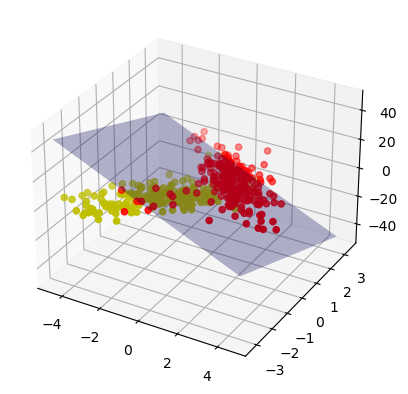

In [60]:
X_train = np.array(X_train)
y_train = np.array(y_train)

x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
# print(x_range)

y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
X, Y = np.meshgrid(x_range, y_range)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], X_train[y_train == 1][:, 2], c='y', marker='o', label='Class 1')
ax.scatter(X_train[y_train == -1][:, 0], X_train[y_train == -1][:, 1], X_train[y_train == -1][:, 2], c='r', marker='o', label='Class -1')

ax.plot_surface(X, Y, (-w[0] * X - w[1] * Y - b) / w[2], color='blue', alpha=0.3, edgecolor='none')
plt.show()

# 9. Visualize the loss function over time during training

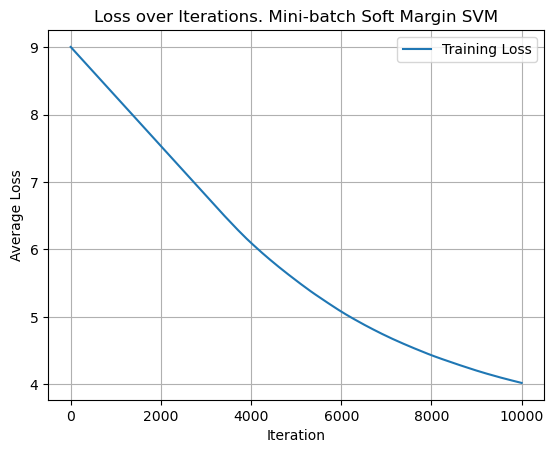

In [61]:
plt.plot(losses, label='Training Loss')
plt.title('Loss over Iterations. Mini-batch Soft Margin SVM')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

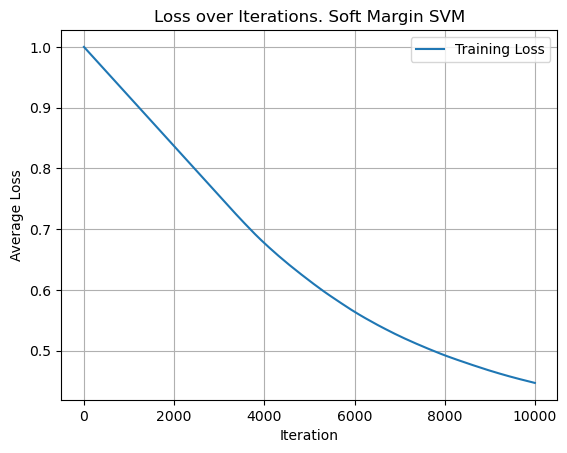

In [62]:
plt.plot(losses1, label='Training Loss')
plt.title('Loss over Iterations. Soft Margin SVM')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

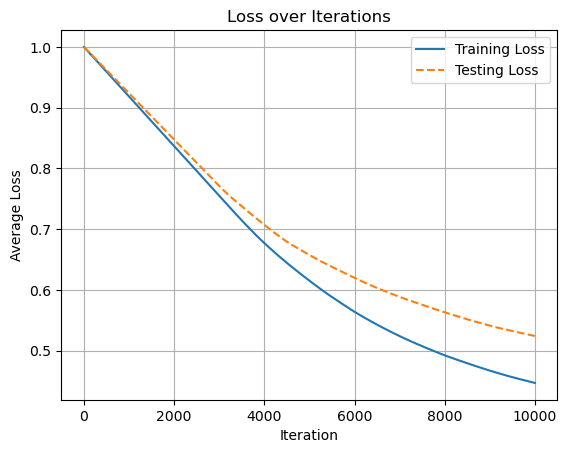

In [63]:
import numpy as np

def sm_svm(X_train, y_train, X_test, y_test, lr=0.0000001, lmbda=0.001):
    np.random.seed(123)
    n_samples, n_features = X_train.shape
    weights = np.random.randn(n_features) * 0.001
    b = 0
    training_losses = []
    testing_losses = []

    for _ in range(10000):
        train_loss = 0
        
        for index, x_i in enumerate(X_train):
            decision_value = np.dot(x_i, weights) + b
            margin = y_train[index] * decision_value
            if margin >= 1:
                weights -= lr * 2 * lmbda * weights
            else:
                b -= lr * y_train[index]
                weights -= lr * (2 * lmbda * weights - y_train[index] * x_i)
                
            train_loss += max(0, 1 - margin)
            
        train_loss += lmbda * np.dot(weights, weights)
        training_losses.append(train_loss / n_samples)
        
        # loss on the testing set
        test_loss = 0
        
        for index, x_i in enumerate(X_test):
            decision_value = np.dot(x_i, weights) + b
            margin = y_test[index] * decision_value
            test_loss += max(0, 1 - margin)

        testing_losses.append(test_loss / len(X_test))

    return weights, b, training_losses, testing_losses

new_weights, new_b, training_losses, testing_losses = sm_svm(X_train, y_train, X_test, y_test)

# Plot the average loss per iteration for both training and testing
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Testing Loss', linestyle='--')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()
